In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
import cv2
import os
import pandas as pd
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.util import random_noise

# --- Helper Function for Plotting ---

def show_image(image, title='', cmap=None, figsize=(5, 5)):
    """Helper function to display an image in a Jupyter Notebook."""
    plt.figure(figsize=figsize)
    if cmap:
        # Show grayscale or heatmap
        plt.imshow(image, cmap=cmap)
    else:
        # Show BGR as RGB
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    plt.title(title)
    plt.axis('off')
    plt.show()
    
print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
class SemiFragileDWTWatermark:
    def __init__(self, wavelet='haar', quant_step=20):
        self.wavelet = wavelet
        self.quant_step = quant_step
        print(f"Watermarker initialized (Wavelet: {self.wavelet}, Quantization Step: {self.quant_step})")

    def _embed_bit(self, coeff, bit):
        quantized = np.round(coeff / self.quant_step)
        if bit == 0 and quantized % 2 != 0:
            quantized -= 1
        elif bit == 1 and quantized % 2 == 0:
            quantized += 1
        return quantized * self.quant_step

    def embed_watermark(self, image_path, watermark_key, output_path='watermarked_image.png'):
        host_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if host_image is None:
            raise FileNotFoundError(f"Image not found at {image_path}")
            
        original_shape = host_image.shape
        host_image = host_image.astype(np.float64)
        
        coeffs = pywt.dwt2(host_image, self.wavelet)
        cA, (cH, cV, cD) = coeffs
        
        watermark_shape = cH.shape
        np.random.seed(watermark_key)
        watermark = np.random.randint(0, 2, size=watermark_shape)
        
        cH_w, cV_w = cH.copy(), cV.copy()
        for i in range(watermark_shape[0]):
            for j in range(watermark_shape[1]):
                bit_to_embed = watermark[i, j]
                cH_w[i, j] = self._embed_bit(cH_w[i, j], bit_to_embed)
                cV_w[i, j] = self._embed_bit(cV_w[i, j], bit_to_embed)
        
        watermarked_coeffs = cA, (cH_w, cV_w, cD)
        watermarked_image = pywt.idwt2(watermarked_coeffs, self.wavelet)
        
        # Ensure output is same size as input, clipping can sometimes be off by one
        watermarked_image = watermarked_image[:original_shape[0], :original_shape[1]]
        
        watermarked_image = np.clip(watermarked_image, 0, 255).astype(np.uint8)
        cv2.imwrite(output_path, watermarked_image)
        
        original_clipped = np.clip(host_image, 0, 255).astype(np.uint8)
        p = psnr(original_clipped, watermarked_image)
        print(f"Watermark embedded (PSNR: {p:.2f} dB). Saved to: {output_path}")

        return watermarked_image, watermark

class TamperDetector:
    def __init__(self, wavelet='haar', quant_step=20):
        self.wavelet = wavelet
        self.quant_step = quant_step

    def _extract_bit(self, coeff):
        quantized = np.round(coeff / self.quant_step)
        return 0 if quantized % 2 == 0 else 1

    def detect_tampering(self, image_path, original_watermark):
        test_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if test_image is None:
            raise FileNotFoundError(f"Image not found at {image_path}")
        
        test_image = test_image.astype(np.float64)
        
        try:
            coeffs = pywt.dwt2(test_image, self.wavelet)
        except ValueError as e:
            print(f"Error during DWT: {e}. Image dimensions may be invalid.")
            return np.ones_like(original_watermark), 100.0

        cA, (cH, cV, cD) = coeffs
        
        # Handle cases where image was cropped
        h, w = original_watermark.shape
        if cH.shape[0] < h or cH.shape[1] < w:
            print("Warning: Image appears cropped. Detecting tampering on remaining area.")
            # Create a full-size error map, default to "tampered" (1)
            tamper_map = np.ones((h, w), dtype=np.uint8)
            
            # Get the smaller dimensions
            h_test, w_test = cH.shape
            
            # Extract bits from the part of the image we still have
            for i in range(h_test):
                for j in range(w_test):
                    bit_h = self._extract_bit(cH[i, j])
                    bit_v = self._extract_bit(cV[i, j])
                    original_bit = original_watermark[i, j]
                    
                    # If either extracted bit is wrong, mark as error
                    error = (bit_h != original_bit) | (bit_v != original_bit)
                    tamper_map[i, j] = 1 if error else 0
        else:
            # Image is not cropped (or was padded), check normally
            tamper_map = np.zeros((h, w), dtype=np.uint8)
            for i in range(h):
                for j in range(w):
                    bit_h = self._extract_bit(cH[i, j])
                    bit_v = self._extract_bit(cV[i, j])
                    original_bit = original_watermark[i, j]
                    error = (bit_h != original_bit) | (bit_v != original_bit)
                    tamper_map[i, j] = 1 if error else 0
        
        tamper_percentage = np.sum(tamper_map) / tamper_map.size * 100
        return tamper_map, tamper_percentage

    def visualize_tamper_map(self, original_image_path, tamper_map):
        original_image = cv2.imread(original_image_path)
        if original_image is None:
            raise FileNotFoundError(f"Image not found at {original_image_path}")

        tamper_map_resized = cv2.resize(
            tamper_map, 
            (original_image.shape[1], original_image.shape[0]), 
            interpolation=cv2.INTER_NEAREST
        )
        
        tamper_map_color = np.zeros_like(original_image)
        tamper_map_color[tamper_map_resized == 1] = [0, 0, 255] # Red (BGR)
        
        overlay = cv2.addWeighted(original_image, 0.4, tamper_map_color, 0.6, 0)
        
        show_image(overlay, title='Tamper Map Overlay (Red = Tampered)')

'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.
'ls' is not recognized as an internal or external command,
operable program or batch file.


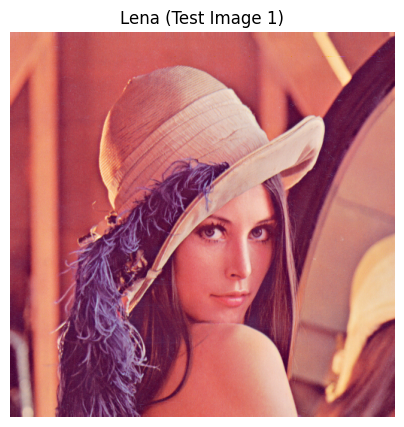

error: OpenCV(4.12.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


<Figure size 500x500 with 0 Axes>

In [3]:
# 1. Get Lena
!wget https://raw.githubusercontent.com/opencv/opencv/master/samples/data/lena.jpg -O lena.jpg

# 2. Get a zip file of other standard test images (peppers, airplane, etc.)
!wget https://www.imageprocessingplace.com/downloads_V3/root_downloads/images_DIP.zip -O images.zip

# 3. Unzip them (quietly)
!unzip -q -o images.zip -d ./
!ls *.tif # Should see airplane.tif, peppers.tif, etc.

# Let's look at our test images
show_image(cv2.imread('lena.jpg'), title='Lena (Test Image 1)')
show_image(cv2.imread('peppers.tif'), title='Peppers (Test Image 2)')

In [4]:
def create_attacks(base_image_path):
    """
    Applies a series of attacks to the base watermarked image and
    saves the results to new files.
    
    Returns a list of (attack_name, attack_file_path) tuples.
    """
    print(f"--- Generating Attacked Images from: {base_image_path} ---")
    
    # Create a directory for our attacked images
    attack_dir = "attacked_images"
    os.makedirs(attack_dir, exist_ok=True)
    
    base_img = cv2.imread(base_image_path)
    base_img_gray = cv2.imread(base_image_path, cv2.IMREAD_GRAYSCALE)
    
    attack_list = []
    
    # --- Attack 1-3: Innocent JPEG Compression ---
    for quality in [90, 70, 50]:
        path = os.path.join(attack_dir, f"attack_jpeg_{quality}.jpg")
        cv2.imwrite(path, base_img, [cv2.IMWRITE_JPEG_QUALITY, quality])
        attack_list.append((f"JPEG Q={quality}", path))
        
    # --- Attack 4: Innocent Mild Blur (e.g., slight refocus) ---
    path = os.path.join(attack_dir, "attack_blur_3x3.png")
    blurred = cv2.blur(base_img, (3, 3))
    cv2.imwrite(path, blurred)
    attack_list.append(("Mild Blur (3x3)", path))
    
    # --- Attack 5: Innocent Mild Noise (e.g., sensor noise) ---
    path = os.path.join(attack_dir, "attack_noise_0.001.png")
    # Need to normalize to [0, 1] for skimage, add noise, then convert back
    img_float = base_img_gray.astype(np.float32) / 255.0
    noisy = random_noise(img_float, mode='gaussian', var=0.001)
    noisy_img = (noisy * 255).astype(np.uint8)
    cv2.imwrite(path, noisy_img)
    attack_list.append(("Gauss Noise (v=0.001)", path))
    
    # --- Attack 6: Malicious Edit (Drawing/Splicing) ---
    path = os.path.join(attack_dir, "attack_edit.png")
    edited = base_img.copy()
    # Draw a black bar over the eyes (for Lena) or on a pepper
    h, w, _ = edited.shape
    cv2.rectangle(edited, (int(w*0.3), int(h*0.4)), (int(w*0.7), int(h*0.5)), (0, 0, 0), -1)
    cv2.imwrite(path, edited)
    attack_list.append(("Malicious Edit (Draw)", path))
    
    # --- Attack 7: Malicious Partial Crop ---
    path = os.path.join(attack_dir, "attack_crop.png")
    # Crop out 25% of the image from the corner
    h, w, _ = base_img.shape
    cropped = base_img[0:int(h*0.75), 0:int(w*0.75)]
    cv2.imwrite(path, cropped)
    attack_list.append(("Partial Crop (25%)", path))
    
    print(f"Generated {len(attack_list)} attacked images in '{attack_dir}/'")
    return attack_list

In [5]:
# --- 1. Set Parameters ---
TEST_IMAGE = 'peppers.tif'
WATERMARKED_IMAGE = 'peppers_watermarked.png'
QUANTIZATION_STEP = 30
WATERMARK_KEY = 12345 

# --- 2. Embed Watermark ---
print("--- Embedding Watermark ---")
embedder = SemiFragileDWTWatermark(wavelet='db1', quant_step=QUANTIZATION_STEP)
watermarked_img, original_watermark = embedder.embed_watermark(
    image_path=TEST_IMAGE, 
    watermark_key=WATERMARK_KEY,
    output_path=WATERMARKED_IMAGE
)
show_image(cv2.imread(TEST_IMAGE), title="Original 'Peppers'")
show_image(watermarked_img, title="Watermarked 'Peppers' (Looks Identical)")

# --- 3. Generate Attacks ---
attacks_to_test = create_attacks(WATERMARKED_IMAGE)

# Add the "no attack" (control) test
attacks_to_test.insert(0, ("Authentic (Control)", WATERMARKED_IMAGE))

# --- 4. Run Detection and Store Results ---
print("\n--- Running Tamper Detection Batch Test ---")
detector = TamperDetector(wavelet='db1', quant_step=QUANTIZATION_STEP)
results = []

for attack_name, image_path in attacks_to_test:
    print(f"Testing: {attack_name}...")
    tamper_map, percentage = detector.detect_tampering(image_path, original_watermark)
    results.append({
        "Attack": attack_name,
        "Tamper (%)": percentage,
        "File": image_path,
        "Map": tamper_map  # Store the map for later visualization
    })

print("--- Batch Test Complete ---")

# --- 5. Display Results in a Table ---
results_df = pd.DataFrame(results, columns=["Attack", "Tamper (%)"])
print("\n--- TEST RESULTS ---")
display(results_df.style.bar(subset=["Tamper (%)"], color='#5fba7d', vmin=0, vmax=100))

--- Embedding Watermark ---
Watermarker initialized (Wavelet: db1, Quantization Step: 30)


FileNotFoundError: Image not found at peppers.tif

In [6]:
# --- Create the Bar Chart ---
plt.figure(figsize=(12, 6))
bars = plt.barh(results_df["Attack"], results_df["Tamper (%)"])
plt.xlabel("Tamper Detection (%)")
plt.title(f"System Accuracy (Tolerance vs. Fragility) | Quantization Step = {QUANTIZATION_STEP}")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.gca().invert_yaxis()  # Put the "Authentic" test at the top

# Add percentage labels to the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2,
             f'{width:.1f}%',
             va='center', ha='left')

plt.show()

NameError: name 'results_df' is not defined

<Figure size 1200x600 with 0 Axes>

In [7]:
# Find the 'Malicious Edit' result from our list
edit_result = next(item for item in results if item["Attack"] == "Malicious Edit (Draw)")
attacked_img_path = edit_result["File"]
tamper_map = edit_result["Map"]

print(f"--- Visualization for: {edit_result['Attack']} ---")
show_image(cv2.imread(attacked_img_path), title="Attacked Image")
detector.visualize_tamper_map(attacked_img_path, tamper_map)

NameError: name 'results' is not defined

In [8]:
# Find the 'Partial Crop' result
crop_result = next(item for item in results if "Partial Crop" in item["Attack"])
attacked_img_path = crop_result["File"]
tamper_map = crop_result["Map"]

print(f"--- Visualization for: {crop_result['Attack']} ---")
show_image(cv2.imread(attacked_img_path), title="Attacked Image (Cropped)")
# We visualize the map on the *cropped* image
detector.visualize_tamper_map(attacked_img_path, tamper_map)

NameError: name 'results' is not defined